# The Daubechies D4 Wavelet Tranform

In [11]:
import numpy as np
import cv2
import IPython
from PIL import Image
import matplotlib.pyplot as plt


def split_matrix(matrix): # divide the matrix into 4 quadrants
    leftSide, rightSide = np.split(matrix, 2, axis=1)
    appr, vD = np.split(leftSide, 2, axis=0)
    hD, dD = np.split(rightSide, 2, axis=0)
    
    return (appr), (hD), (vD), (dD)

def imshow(image, width=None):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret, width=width)
    IPython.display.display(i)

def jpg_to_pgm(jpg_path):
    image = Image.open(jpg_path)
    image_gray = image.convert('L')
    width = image_gray.size[0]
    if (width>512):
        image_gray = image_gray.resize((512, 512))
        pixels = list(image_gray.getdata())

    else: pixels = list(image_gray.getdata())

    return np.array(pixels).reshape((512, 512))

def new_p(matrix):
    max,min  = np.max(matrix), np.min(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] = ((matrix[i][j]-min)*255.0)/(max-min)
    return matrix

In [2]:
def function_daubechies_coeffs(image):
    rows, cols = image.shape
    matrix_coeffs = np.zeros((rows, cols))

    for i in range(rows // 2):
        if i < rows // 2 - 1: 
            matrix_coeffs[i, 2 * i:2 * i + 4] = h_coeffs
        else:
            matrix_coeffs[i, 2 * i:2 * i + 2] = h_coeffs[:2]
            matrix_coeffs[i, 0:2] = h_coeffs[2:]

    for i in range(rows // 2):
        if i < rows // 2 - 1:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 4] = g_coeffs
        else:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 2] = g_coeffs[:2]
            matrix_coeffs[i + rows // 2, 0:2] = g_coeffs[2:]

    return (np.round(matrix_coeffs, 4))
        

# def inverse_daubechies4_wavelet_transform_2D(daubechies_coeffs, result_V):
#     daubechies_coeffs_transpose = np.transpose(daubechies_coeffs)
#     result_H = np.dot(daubechies_coeffs_transpose, result_V)

#     image = []
#     for row in result_H:
#         original_row = np.dot(daubechies_coeffs_transpose, row)
#         image.append(original_row)

#     return np.array(image)

root2, root3 = np.sqrt(2), np.sqrt(3) 

h_coeffs = np.array([(1 + root3) / (4 * root2),
                     (3 + root3) / (4 * root2),
                     (3 - root3) / (4 * root2),
                     (1 - root3) / (4 * root2)])

g_coeffs = np.array([h_coeffs[3], 
                    -h_coeffs[2],
                     h_coeffs[1], 
                    -h_coeffs[0]])

In [50]:
def daubechies4_wavelet_transform_2D(daubechies_coeffs,image,scale,width, details = None):
    result_H = []

    for row in image: #ESTA PARTE HACE LA HORIZONTAL
        result_H.append(np.dot(daubechies_coeffs,row))
    result_V = np.dot(daubechies_coeffs,result_H)

    if (scale == 1) :
        if details is not None:
            normalized = np.copy(result_V)
            for i in range(len(details)//3):
                sup_img = np.concatenate((result_V,details[0+(i*3)]), axis=1)
                inf_img = np.concatenate((details[1+(i*3)],details[2+(i*3)]), axis=1)
                result_V = np.concatenate((sup_img,inf_img), axis=0)


                aP,cH,cV,cD = split_matrix(normalized)
                sup_img_normal = np.concatenate((new_p(aP),new_p(cH)), axis=1)
                inf_img_normal = np.concatenate((new_p(cV),new_p(cD)), axis=1)
                normalized = np.concatenate((sup_img_normal,inf_img_normal), axis=0)
                sup_img_normal = np.concatenate((new_p(normalized),new_p(details[0+(i*3)])), axis=1)
                inf_img_normal = np.concatenate((new_p(details[1+(i*3)]),new_p(details[2+(i*3)])), axis=1)
                normalized = np.concatenate((sup_img_normal,inf_img_normal), axis=0)
                
            return result_V, normalized
        else:
            normalized = np.copy(result_V)
            aP,cH,cV,cD = split_matrix(normalized)
            sup_img_normal = np.concatenate((new_p(aP),new_p(cH)), axis=1)
            inf_img_normal = np.concatenate((new_p(cV),new_p(cD)), axis=1)
            normalized = np.concatenate((sup_img_normal,inf_img_normal), axis=0)
            return result_V, normalized
        
    elif (np.log2(width//4) >= scale > 1):
        aP,cH,cV,cD = split_matrix(result_V)
        details = ([cH,cV,cD] + details) if details is not None else [cH,cV,cD]
        return daubechies4_wavelet_transform_2D(function_daubechies_coeffs(aP),aP,scale-1,aP.shape[0],details)

    else : print(f"The scale value has to be between 1 - {np.log2(width//4)}")

In [4]:
example = np.random.randint(0.0, 52.0, (8, 8))
example_daubechies_4 = function_daubechies_coeffs(example)
example_daubechies_4_transposed = np.transpose(example_daubechies_4)
print(f"\nCoeffs Matrix:\n {example_daubechies_4}")
print(f"\nCoeffs Matrix Transposed:\n {example_daubechies_4_transposed}")



Coeffs Matrix:
 [[ 0.483   0.8365  0.2241 -0.1294  0.      0.      0.      0.    ]
 [ 0.      0.      0.483   0.8365  0.2241 -0.1294  0.      0.    ]
 [ 0.      0.      0.      0.      0.483   0.8365  0.2241 -0.1294]
 [ 0.2241 -0.1294  0.      0.      0.      0.      0.483   0.8365]
 [-0.1294 -0.2241  0.8365 -0.483   0.      0.      0.      0.    ]
 [ 0.      0.     -0.1294 -0.2241  0.8365 -0.483   0.      0.    ]
 [ 0.      0.      0.      0.     -0.1294 -0.2241  0.8365 -0.483 ]
 [ 0.8365 -0.483   0.      0.      0.      0.     -0.1294 -0.2241]]

Coeffs Matrix Transposed:
 [[ 0.483   0.      0.      0.2241 -0.1294  0.      0.      0.8365]
 [ 0.8365  0.      0.     -0.1294 -0.2241  0.      0.     -0.483 ]
 [ 0.2241  0.483   0.      0.      0.8365 -0.1294  0.      0.    ]
 [-0.1294  0.8365  0.      0.     -0.483  -0.2241  0.      0.    ]
 [ 0.      0.2241  0.483   0.      0.      0.8365 -0.1294  0.    ]
 [ 0.     -0.1294  0.8365  0.      0.     -0.483  -0.2241  0.    ]
 [ 0.      0.   

In [5]:
print(f"Original Matrix:\n {example}\n")
dwt = daubechies4_wavelet_transform_2D(example_daubechies_4,example,1,example.shape[0])
# idwt = inverse_daubechies4_wavelet_transform_2D(example_daubechies_4,dwt)
print(f"\nDirect Daubechies Wavelet Transform:\n {np.round(dwt,4)}")

Original Matrix:
 [[27 50 19 48 23 48 17  9]
 [ 0 43 16 37 34 50 18 11]
 [10  3  7 28 40 19 42 11]
 [34 41 28 32  4 34 21 44]
 [19 29 20 34 39 10 35 46]
 [17 32 44 12 37 26  9 32]
 [35 41 23 46 24 30 32 30]
 [ 2 26  4 13 32 49 30 29]]


Direct Daubechies Wavelet Transform:
 [[ 48.9849  59.3354  82.823   18.3635 -23.8667  -6.4452  -0.6682 -23.8867]
 [ 48.6738  52.3823  47.1155  64.8872 -14.0946  -9.0613   2.3052  -5.4347]
 [ 60.8562  61.9783  46.6878  57.7648  11.3488  15.1846 -14.5496 -11.8213]
 [ 50.0475  41.7452  73.2145  52.6233 -18.7081  -7.0544  -2.2977 -16.4476]
 [-35.7451  -5.0784   1.3319  -2.3237   0.6662  29.4166  24.576    7.5567]
 [ -5.3978   8.0525  -5.9499  16.7875 -15.1804  13.0124   8.7764  -5.2004]
 [ 17.5329  22.1353  -7.4248   4.6063 -13.34   -10.7995   8.182   12.9301]
 [ 16.0323  11.4763  -2.7895  -6.7464  -7.3911 -10.3518   0.1892  12.4566]]


## IMAGES EXAMPLES

In [21]:
photo = 'imagen.jpg'

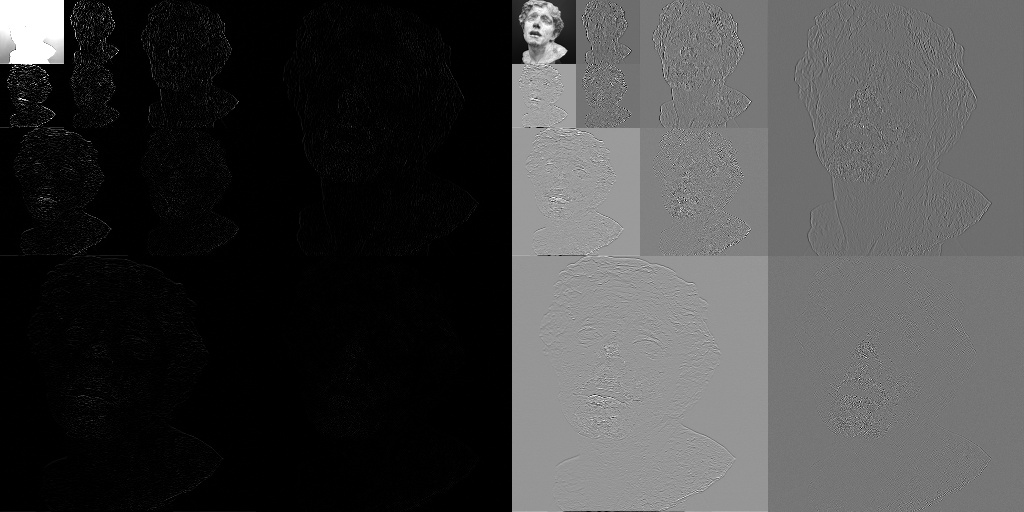

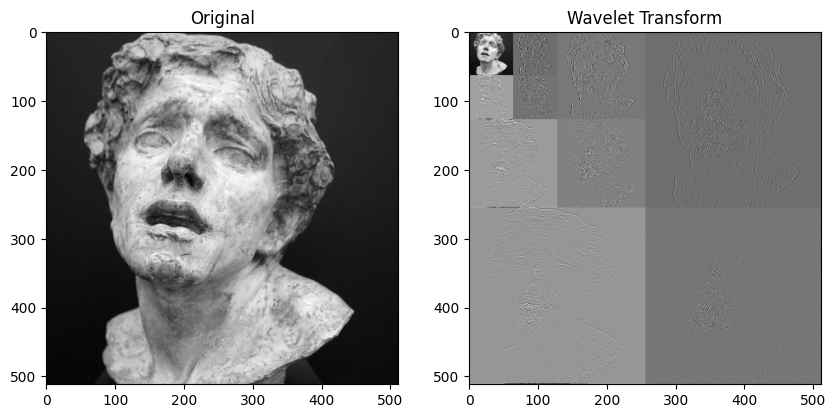

In [59]:
array_photo = jpg_to_pgm(photo)
daubechies_4 = function_daubechies_coeffs(array_photo)
scale, width = 3, array_photo.shape[0]
result_img, normalized= daubechies4_wavelet_transform_2D(daubechies_4,array_photo,scale,width)
# reconstructed = daubechies4_wavelet_inverse_transform_2D(daubechies_4,result_img, scale, width)

imshow(np.concatenate((result_img,normalized), axis = 1))

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(array_photo, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow((normalized), cmap='gray')
ax[1].set_title('Wavelet Transform')
plt.show()